In [ ]:
# default_exp model

In [ ]:
#export
import fastai
from fastai import *
from fastai.vision import *
from fastai.vision import learner as ln
import sys
sys.path.append("../")
from acdc.dataprep import *

# from fastai.data_block import *
# import nibabel as nib
# from fastai.callbacks import *
# from fastai.vision.data import SegmentationProcessor

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
path = Path('/media/ismael/01D2273CA76327A0/datasets/acdc_MICCAI17/acdc_train')

# Model

> Set up any segmentation model for MRI images.
Here we will use the the **Unet based on resnet encoder** that's built-in `fastai`.
Our data has the shape `[batch_size, n_slices, 3, width, height]` (see `dataprep` module).
We are going to transform the shape to `[batch_size * n_slices, 3, width, height]` to make
it consumable by the Unet.
                                                                                                                Our approach is to add a layer at the begining of the Unet to operate this transformation and
a another layer at the end of the Unet to get back to original shape.


In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
def to_images(mri:Tensor)->Tensor:
    return torch.cat([*mri])

def to_mri(images:Tensor, bs:int=None)->Tensor:
    assert bs != None, 'Must indicate bs'
    n_slices = images.shape[0] // bs
    return images.reshape(bs, n_slices, *images.shape[1:])

In [ ]:
bs = 5
n_slices = 10
mri = torch.rand(bs, n_slices, 3, 7, 7)
print(f'mri shape: {mri.shape}')

mri shape: torch.Size([5, 10, 3, 7, 7])


In [ ]:
img = to_images(mri)
print(f'img shape: {img.shape}')
assert img.shape == torch.Size([bs*n_slices, *mri.shape[-3:]])
mri0 = to_mri(img, bs)
print(f'mri0 shape: {mri0.shape}')
assert mri0.shape == torch.Size([bs, n_slices, *mri.shape[-3:]])
assert (mri0 == mri).all(), "reshaping back to mri is incorrect."

img shape: torch.Size([50, 3, 7, 7])
mri0 shape: torch.Size([5, 10, 3, 7, 7])


In [ ]:
v_idxs = [0, 2, 9, 4]
codes = np.array(['background', "RV", 'Myocardium', 'LV'])
get_mask = lambda fn: fn[:-7]+'_gt.nii.gz'
data = (MRISegItemList.from_csv(path, 'data_sample.csv')
                   .split_by_idx(v_idxs)
                   .label_from_func(get_mask, classes=codes)
                   .transform(get_transforms(), size=(3,100, 122), tfm_y=True)
                   .databunch(bs=3)
       )

In [ ]:
data

ImageDataBunch;

Train: LabelList (6 items)
x: MRISegItemList
MRImage (3, 3, 100, 122),MRImage (3, 3, 100, 122),MRImage (3, 3, 100, 122),MRImage (3, 3, 100, 122),MRImage (3, 3, 100, 122)
y: MRImageSegLabelList
MRImageSegment (3, 1, 100, 122),MRImageSegment (3, 1, 100, 122),MRImageSegment (3, 1, 100, 122),MRImageSegment (3, 1, 100, 122),MRImageSegment (3, 1, 100, 122)
Path: /media/ismael/01D2273CA76327A0/datasets/acdc_MICCAI17/acdc_train;

Valid: LabelList (4 items)
x: MRISegItemList
MRImage (3, 3, 100, 122),MRImage (3, 3, 100, 122),MRImage (3, 3, 100, 122),MRImage (3, 3, 100, 122)
y: MRImageSegLabelList
MRImageSegment (3, 1, 100, 122),MRImageSegment (3, 1, 100, 122),MRImageSegment (3, 1, 100, 122),MRImageSegment (3, 1, 100, 122)
Path: /media/ismael/01D2273CA76327A0/datasets/acdc_MICCAI17/acdc_train;

Test: None

In [ ]:
#export
class MyDynamicUnet(models.unet.DynamicUnet):
    
    def __init__(self, encoder, bs=None, **kwargs):
        assert bs != None, 'Must indicate bs'
        self.bs = bs
        super().__init__(encoder, **kwargs)
        
    def forward(self, x):
        x = to_images(x)
        res = super().forward(x)
        res = to_mri(res, self.bs)
        return res

def unet4mri_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=None, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
                 self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None, **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    meta = ln.cnn_config(arch)
    body = ln.create_body(arch, pretrained, cut)
    try:    size = data.train_ds[0][0].size
    except: size = next(iter(data.train_dl))[0].shape[-2:]
    model = to_device(MyDynamicUnet(body, bs=data.batch_size, n_classes=data.c, img_size=size, blur=blur, blur_final=blur_final,
          self_attention=self_attention, y_range=y_range, norm_type=norm_type, last_cross=last_cross,
          bottle=bottle), data.device)
    learn = Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on, meta['split']))
    if pretrained: learn.freeze()
    apply_init(model[2], nn.init.kaiming_normal_)
    return learn

In [ ]:
unet = unet4mri_learner(data, models.resnet18)

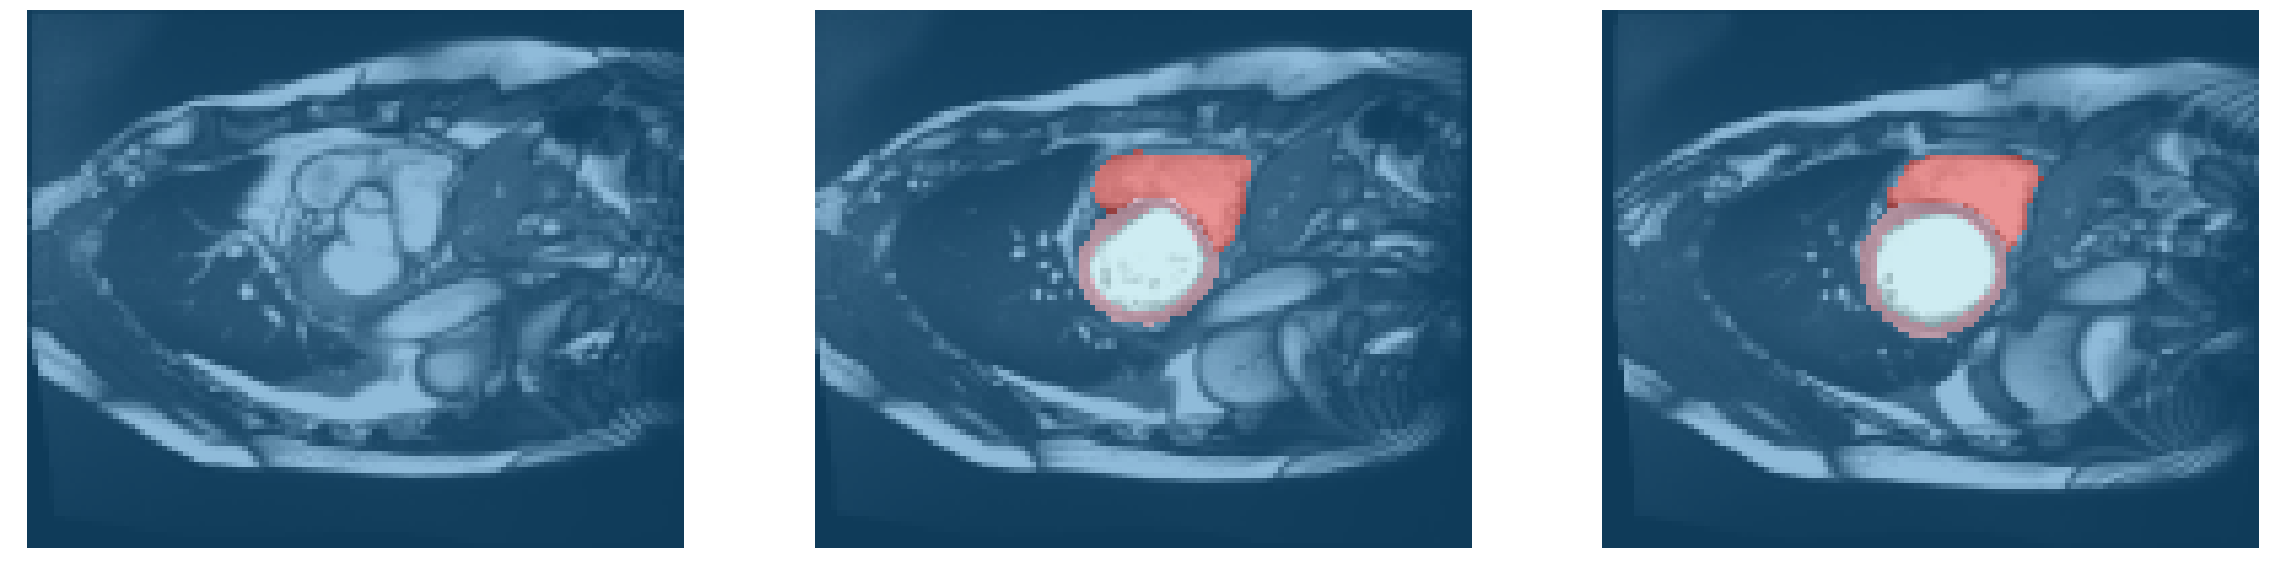

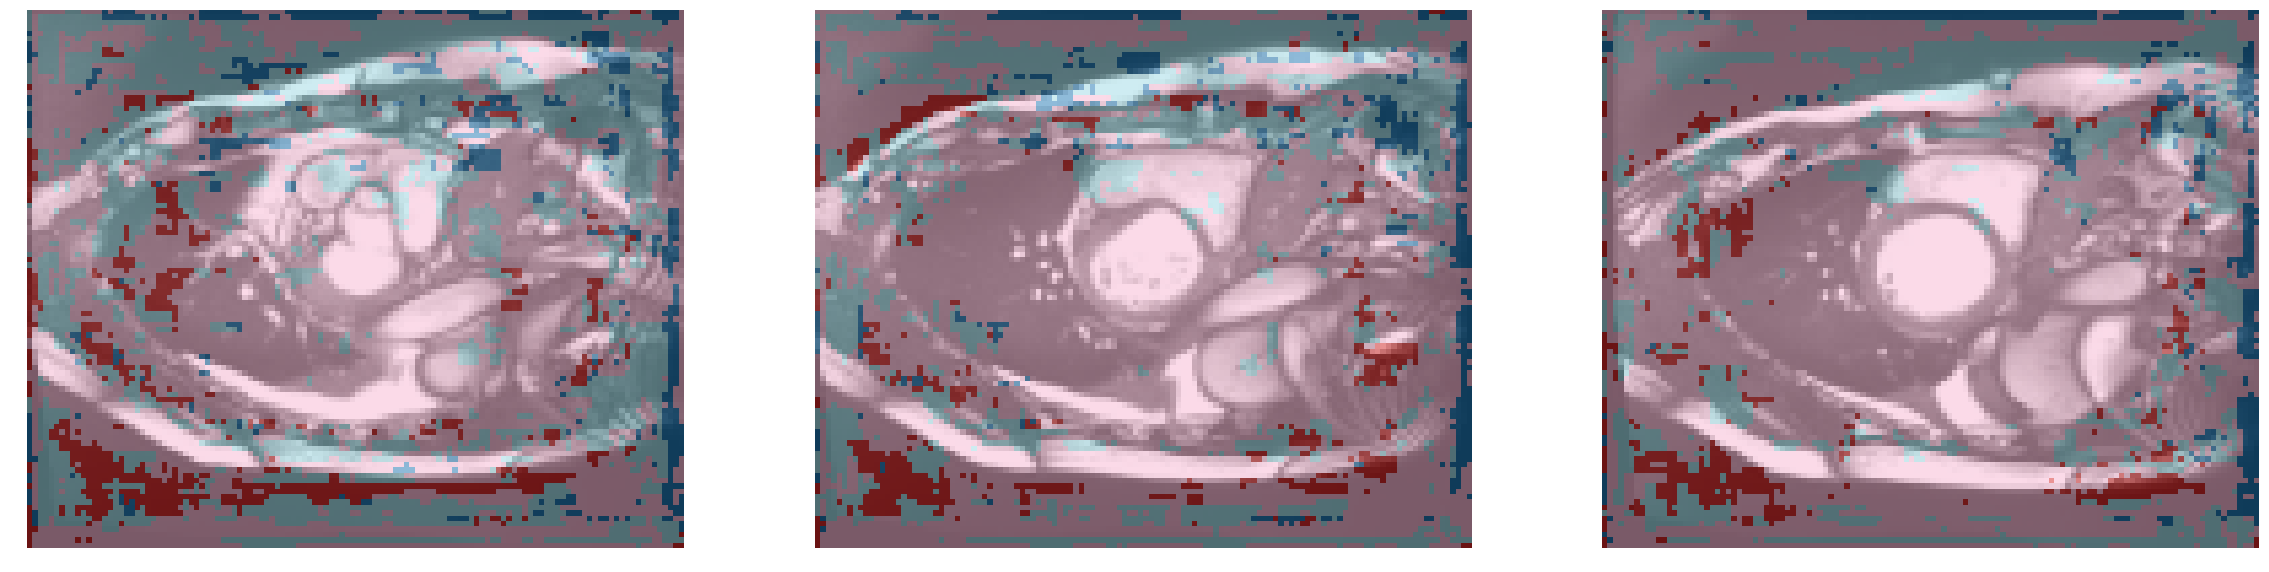

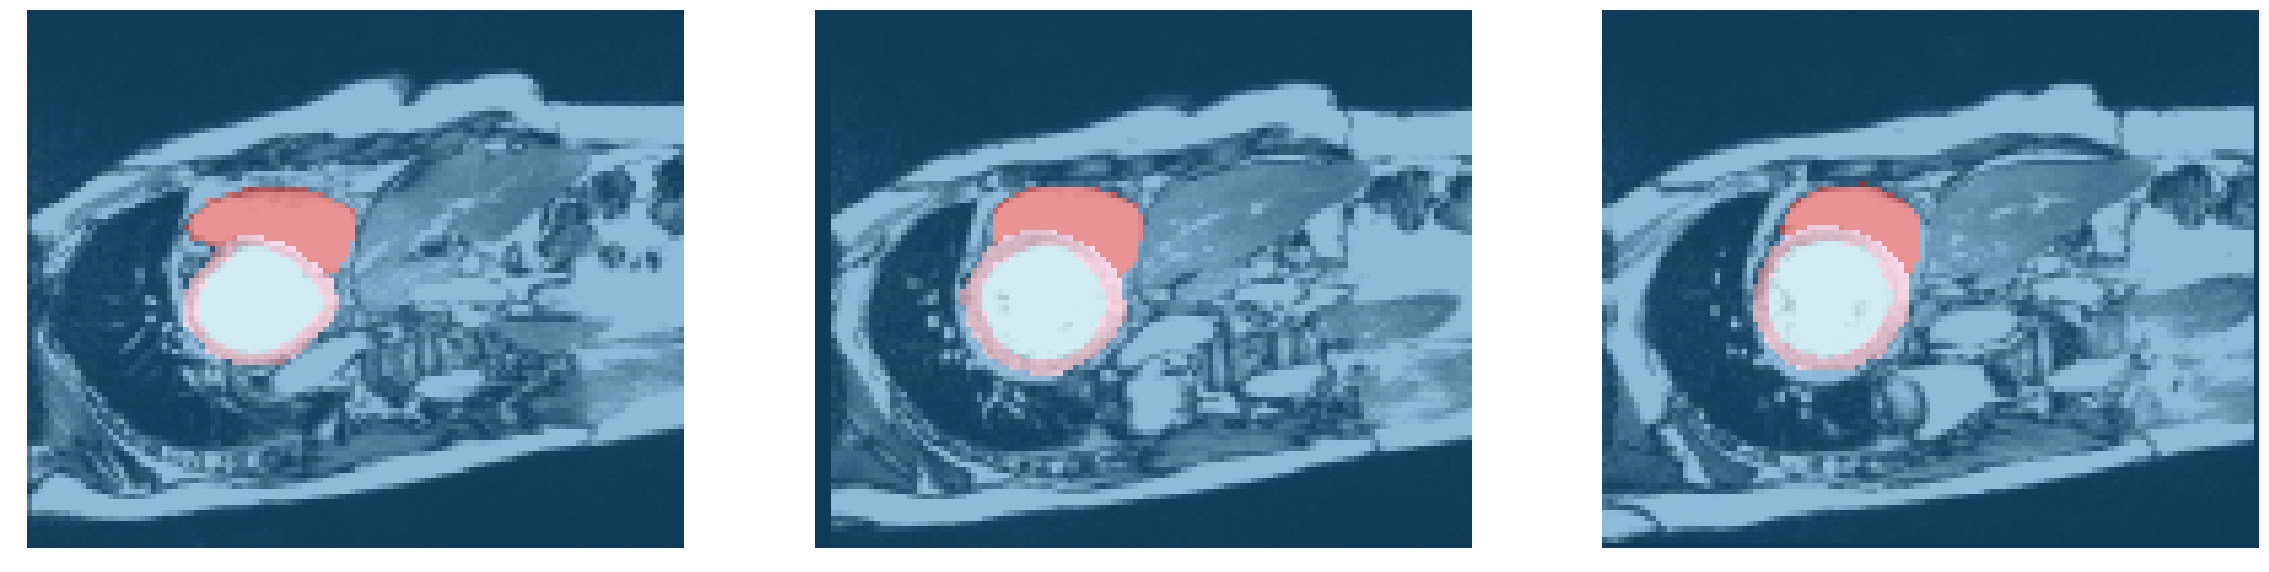

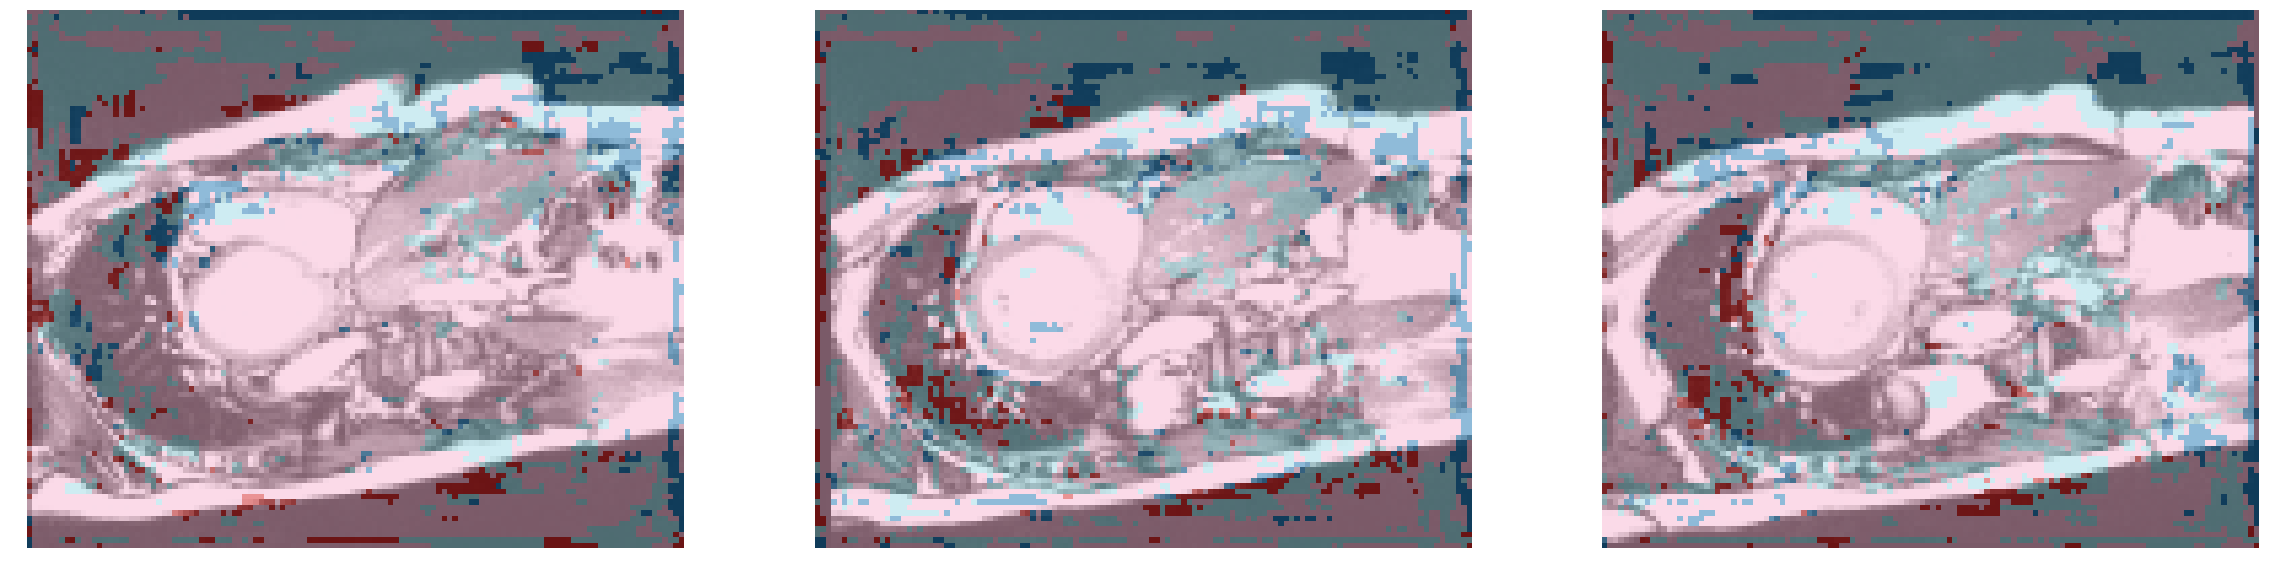

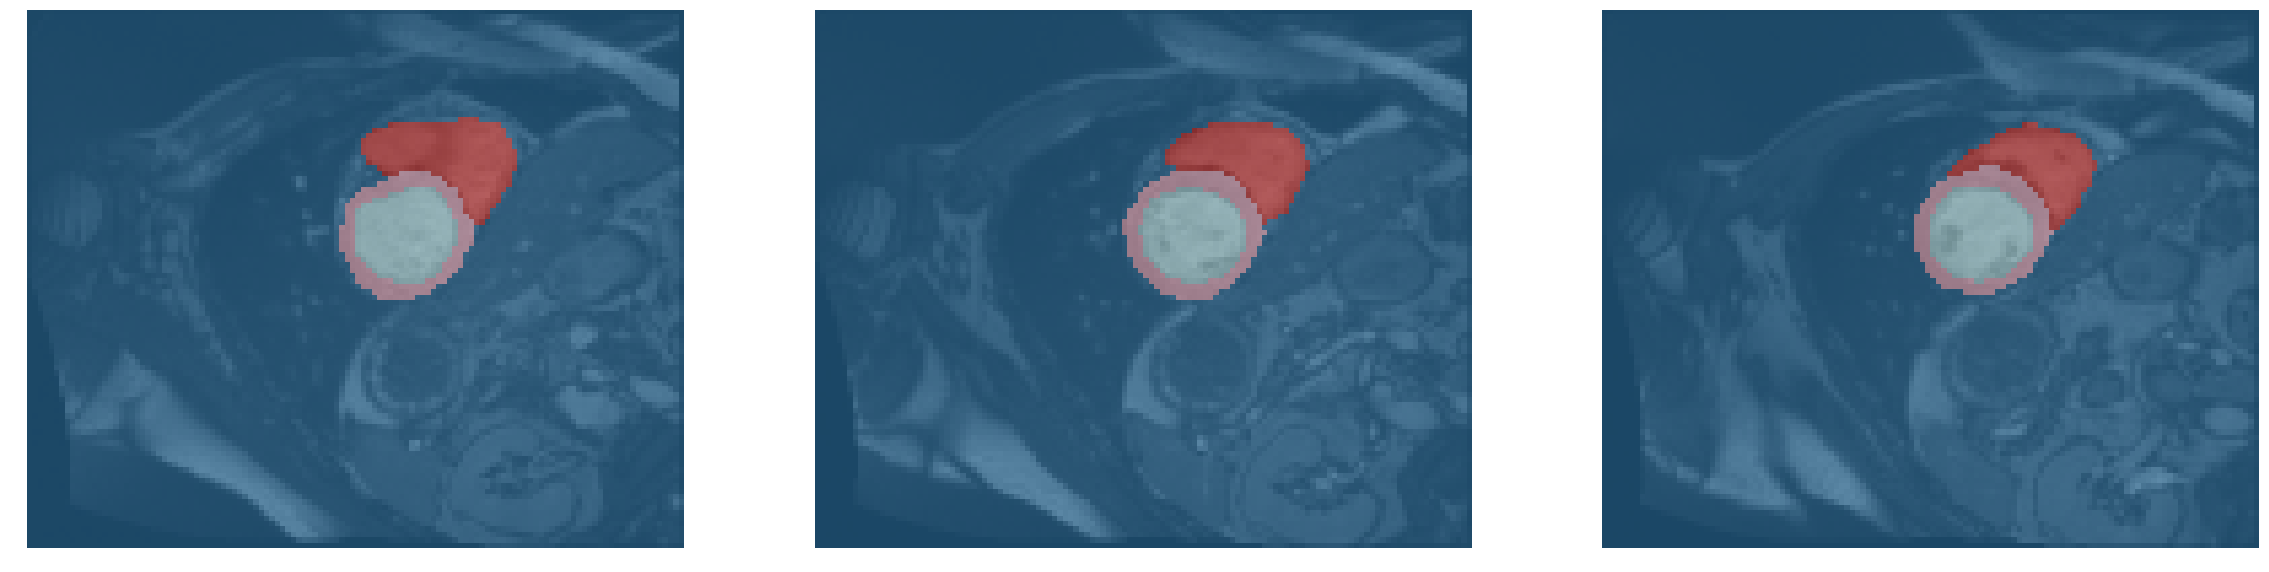

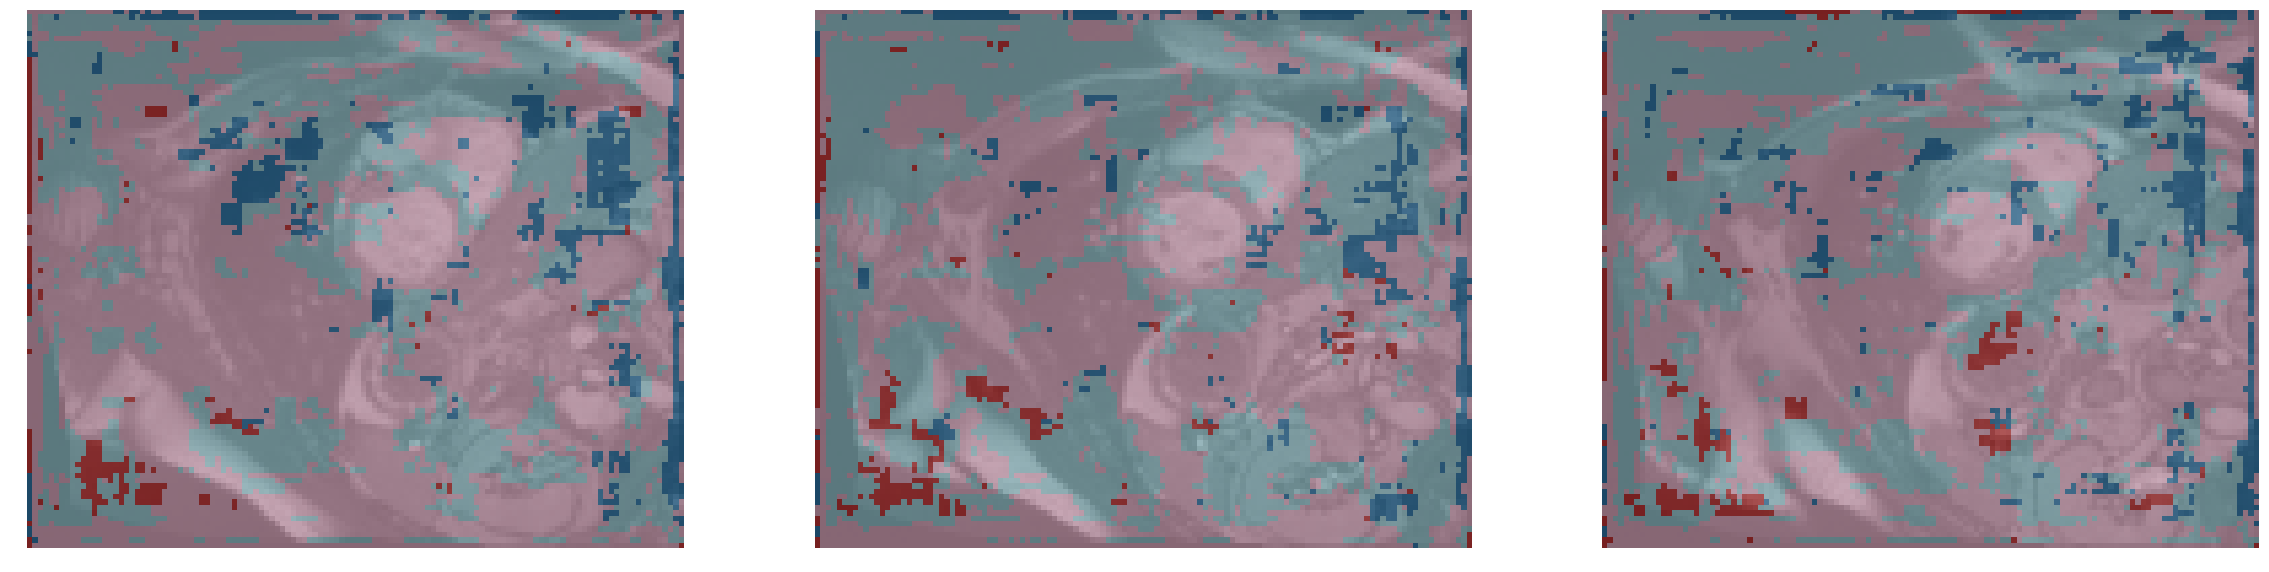

In [ ]:
unet.show_results(slice_idxs=np.arange(3))

In [ ]:
unet.fit_one_cycle(17)

epoch,train_loss,valid_loss,time
0,0.169759,0.269699,00:10
1,0.162336,0.189632,00:10
2,0.155879,0.236389,00:10
3,0.152259,0.158050,00:10
4,0.149089,0.170928,00:10
5,0.145767,0.185677,00:10
6,0.143780,0.125206,00:11
7,0.137353,0.317399,00:11
8,0.131018,0.127093,00:11
9,0.125006,0.348206,00:10


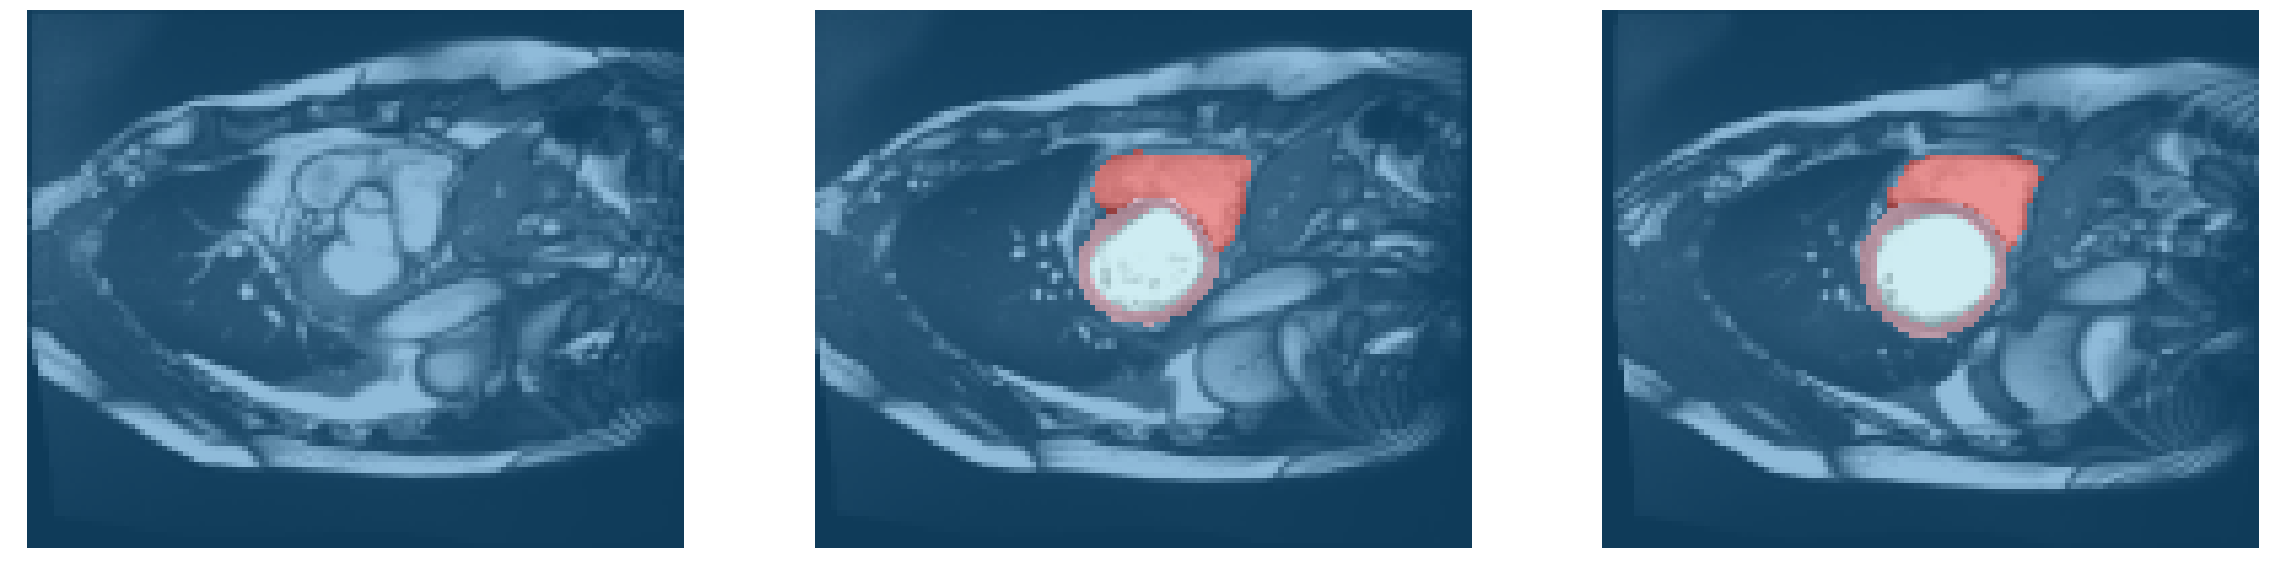

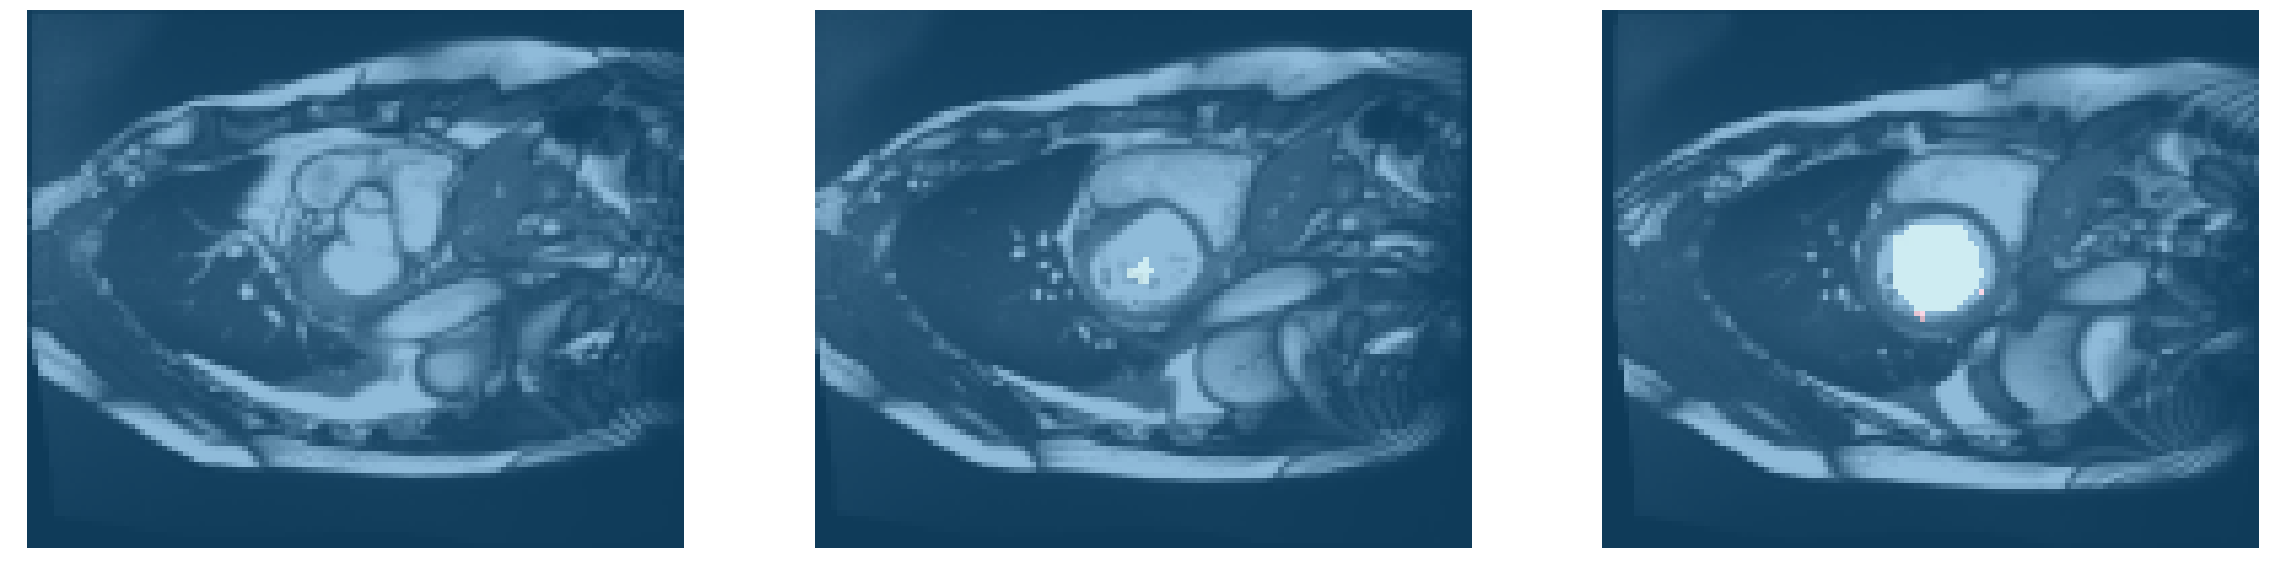

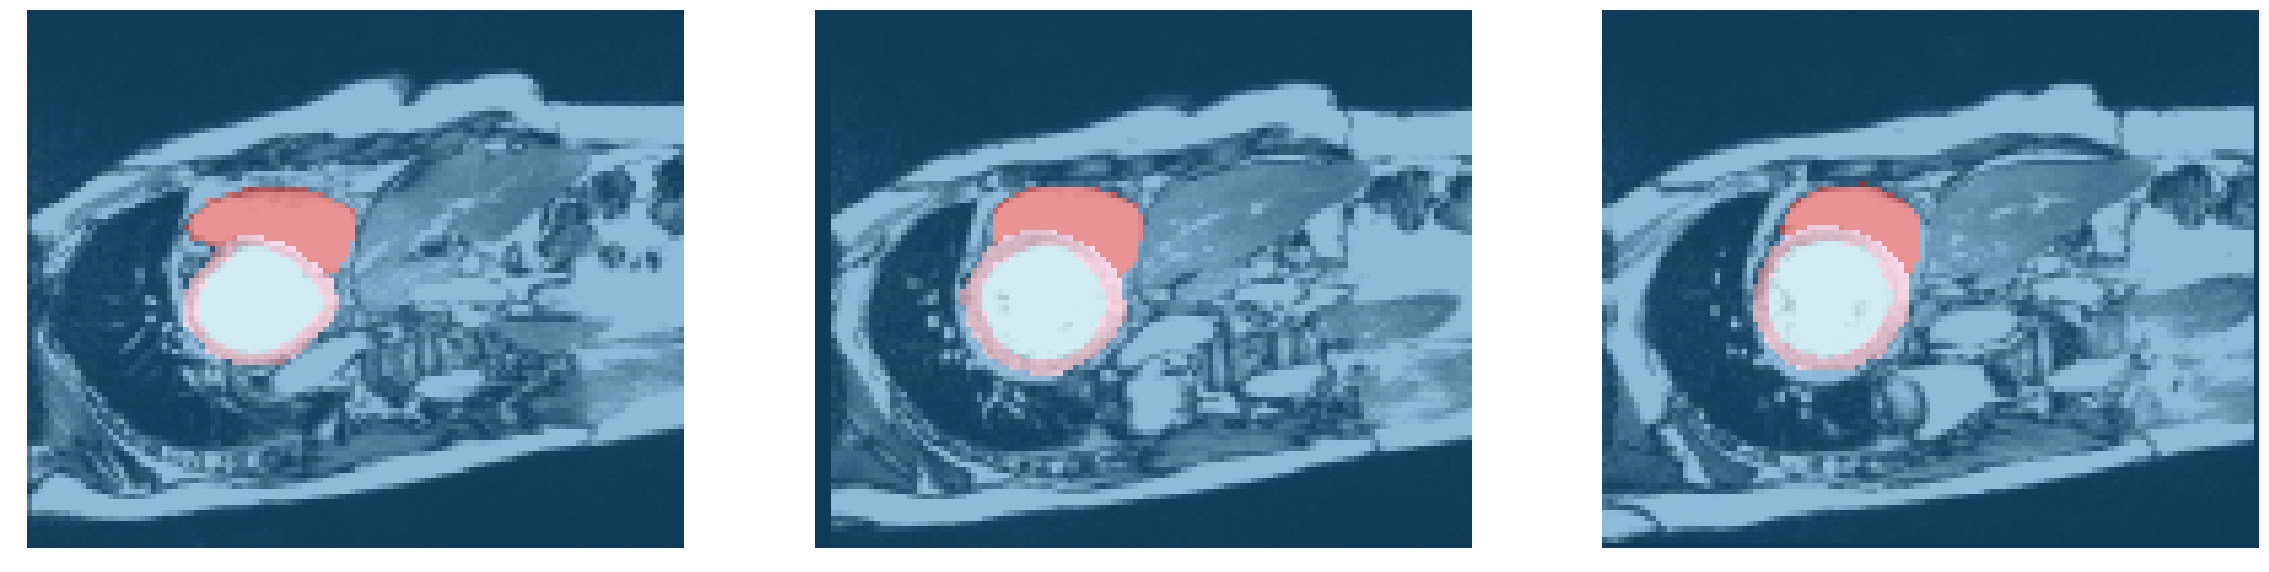

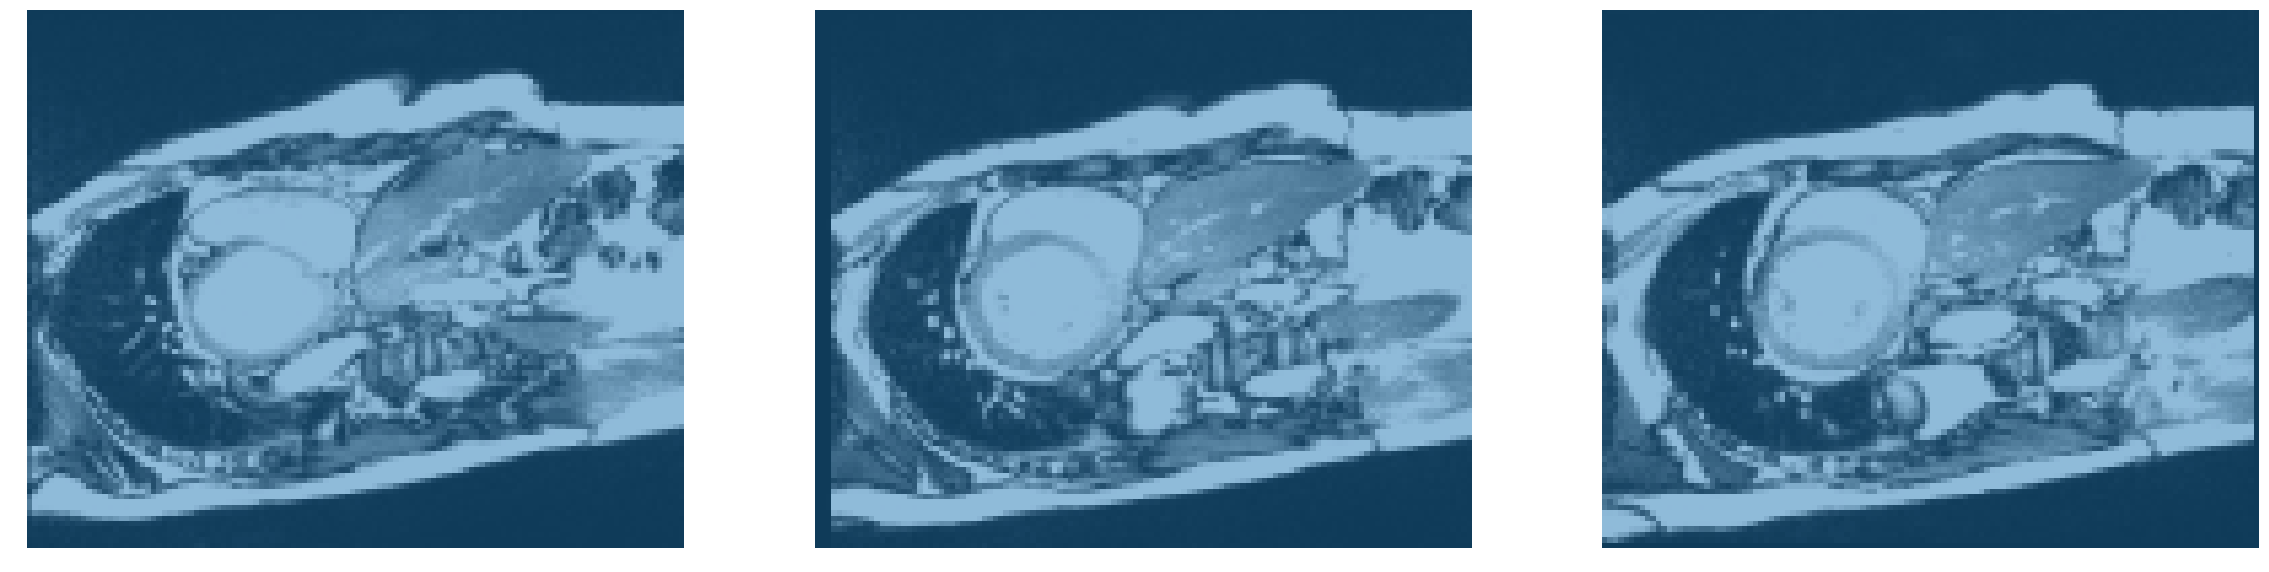

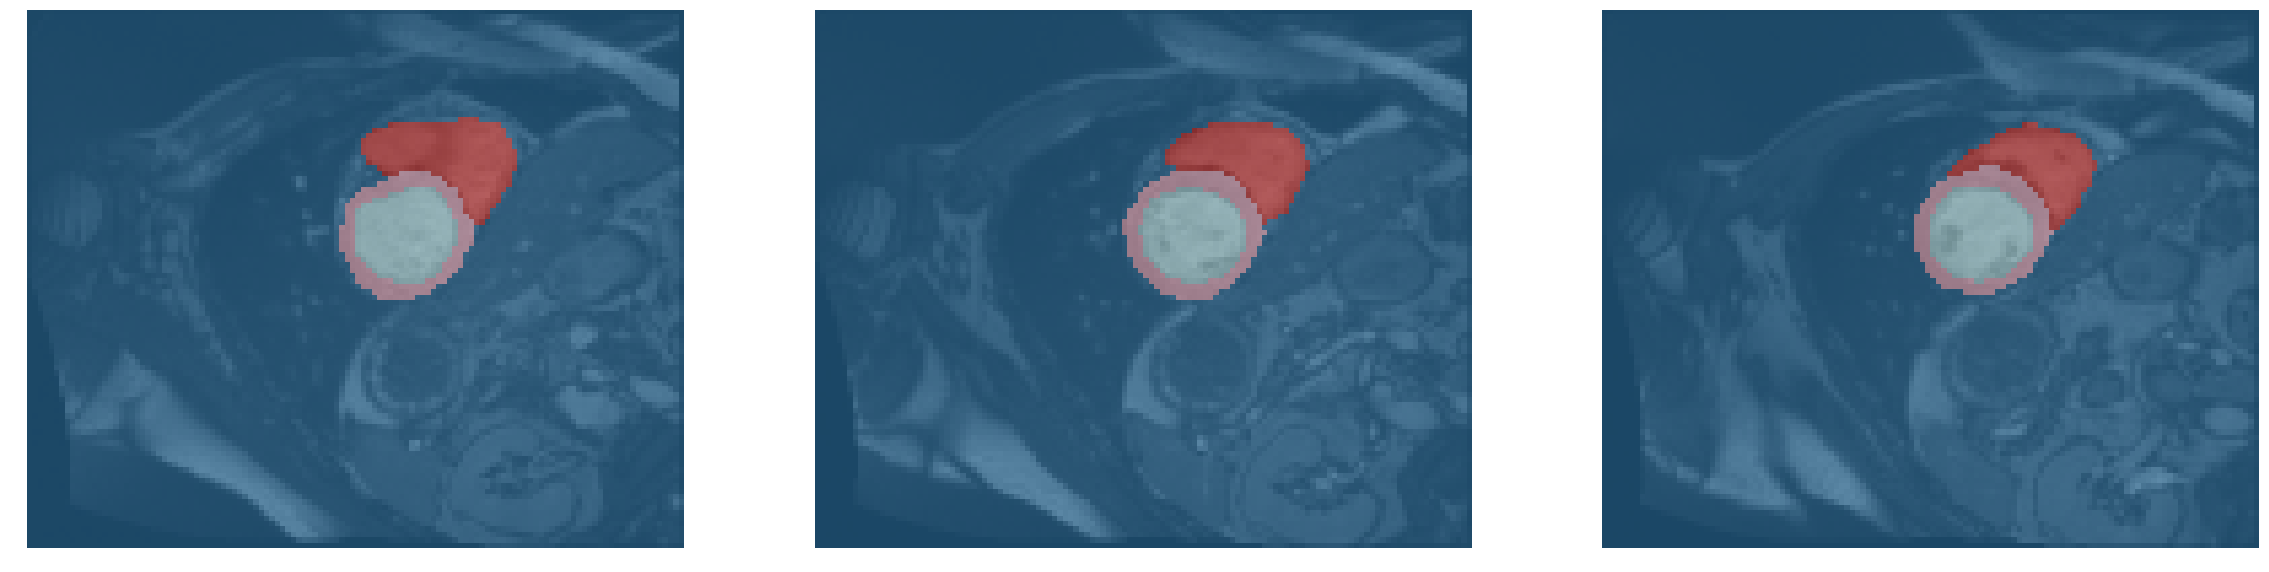

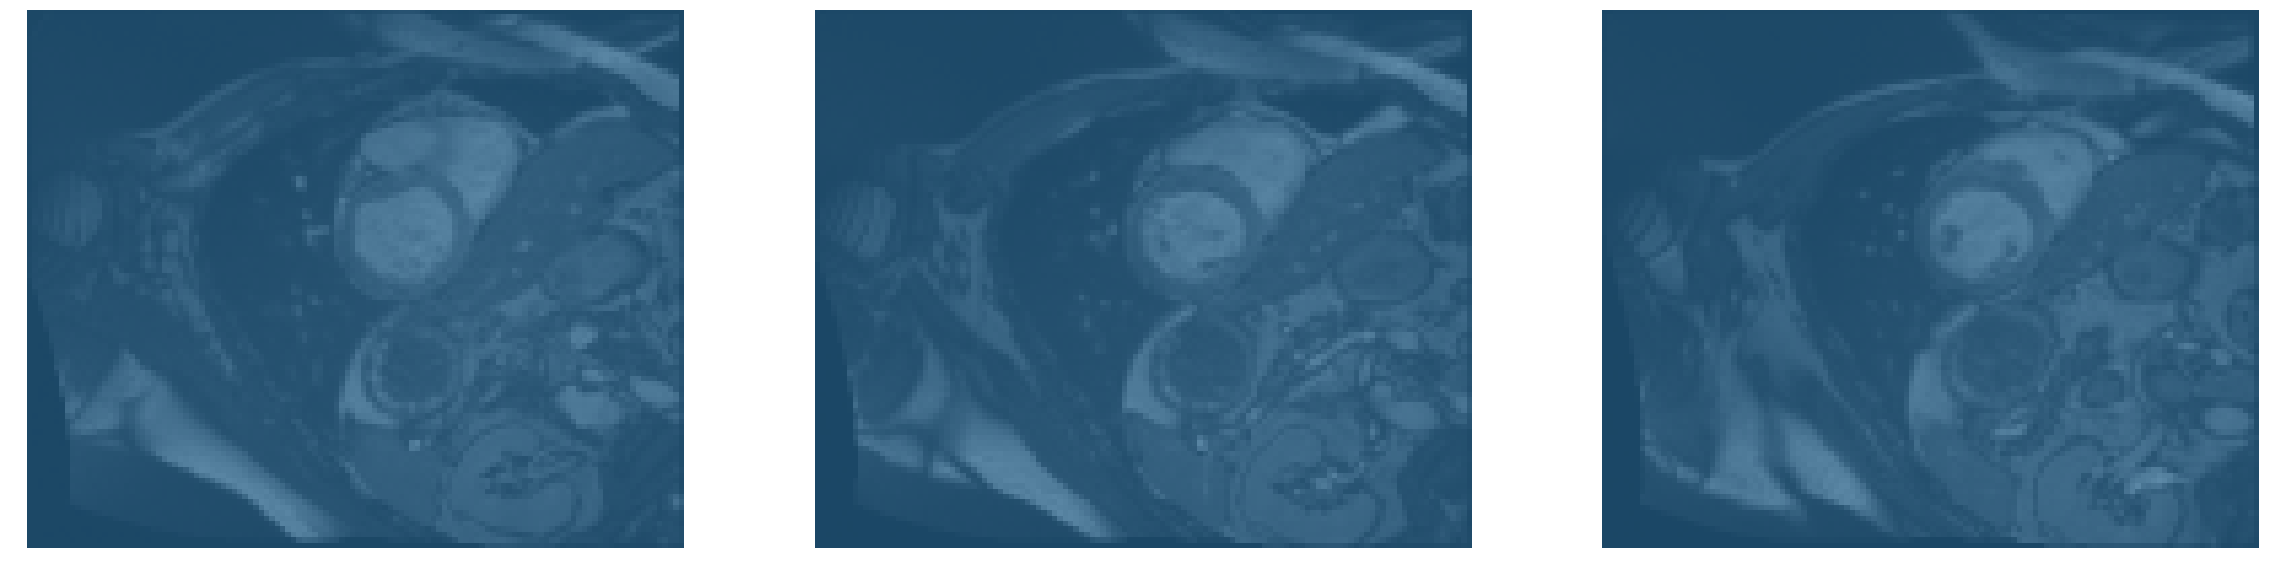

In [ ]:
unet.show_results(slice_idxs=np.arange(3))